In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as U
from scipy.constants import c

parent_dir=os.path.dirname(os.getcwd())



In [14]:



sed = sed_reading("point", os.path.join(parent_dir, 'brightnes'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   um        5001 non-null   float64
 1   erg/s/Hz  5001 non-null   float64
dtypes: float64(2)
memory usage: 78.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   um        5001 non-null   float64
 1   erg/s/Hz  5001 non-null   float64
dtypes: float64(2)
memory usage: 78.3 KB


In [ ]:
db = pd.read_csv(os.path.join(parent_dir, 'brightnes','SED_low_z_type2_AGN.dat'), sep='\s+')
db2= pd.read_csv(os.path.join(parent_dir, 'brightnes','SED_low_z_warm_star_forming_galaxy.dat'), sep='\s+')
db['Frequency'] = u.Quantity(db['um'], unit=u.micrometer).to(u.GHz, equivalencies=u.spectral())
db2['Frequency'] =  u.Quantity(db2['um'], unit=u.micrometer).to(u.GHz, equivalencies=u.spectral())
plt.figure(figsize=[10,8])
plt.plot(db['um'],db['erg/s/Hz'], color='green', label='SED_low_z_type2_AGN')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log$\lambda$(${\mu}m$)')
plt.ylabel('log(PSD)(erg/s/Hz)')
plt.legend()
plt.show()
plt.figure(figsize=[10,8])
plt.plot(db2['um'],db2['erg/s/Hz'], color='red',label='SED_low_z_warm_star_forming_galaxy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log$\lambda$(${\mu}m$)')
plt.ylabel('log(PSD)(erg/s/Hz)')
plt.legend()
plt.show()

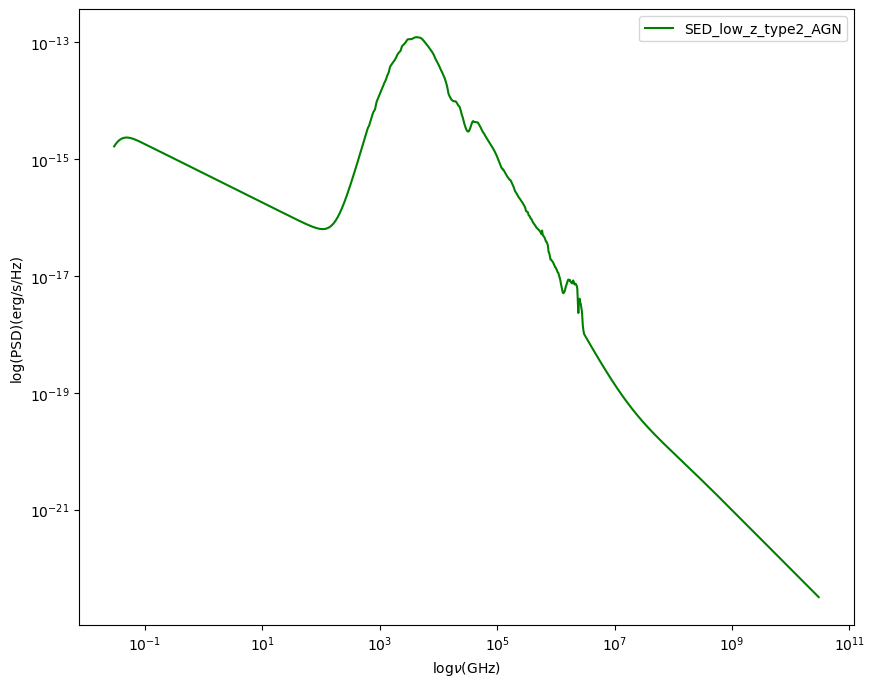

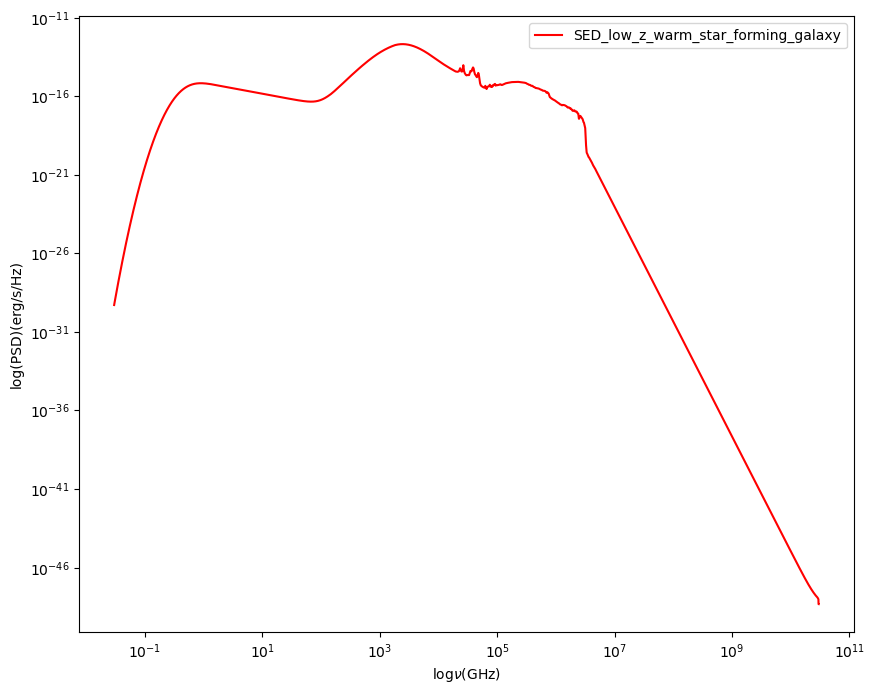

In [3]:
plt.figure(figsize=[10,8])
plt.plot(db['Frequency'],db['erg/s/Hz'], color='green', label='SED_low_z_type2_AGN')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log$\\nu$(GHz)')
plt.ylabel('log(PSD)(erg/s/Hz)')
plt.legend()
plt.show()
plt.figure(figsize=[10,8])
plt.plot(db2['Frequency'],db2['erg/s/Hz'], color='red',label='SED_low_z_warm_star_forming_galaxy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log$\\nu$(GHz)')
plt.ylabel('log(PSD)(erg/s/Hz)')
plt.legend()
plt.show()

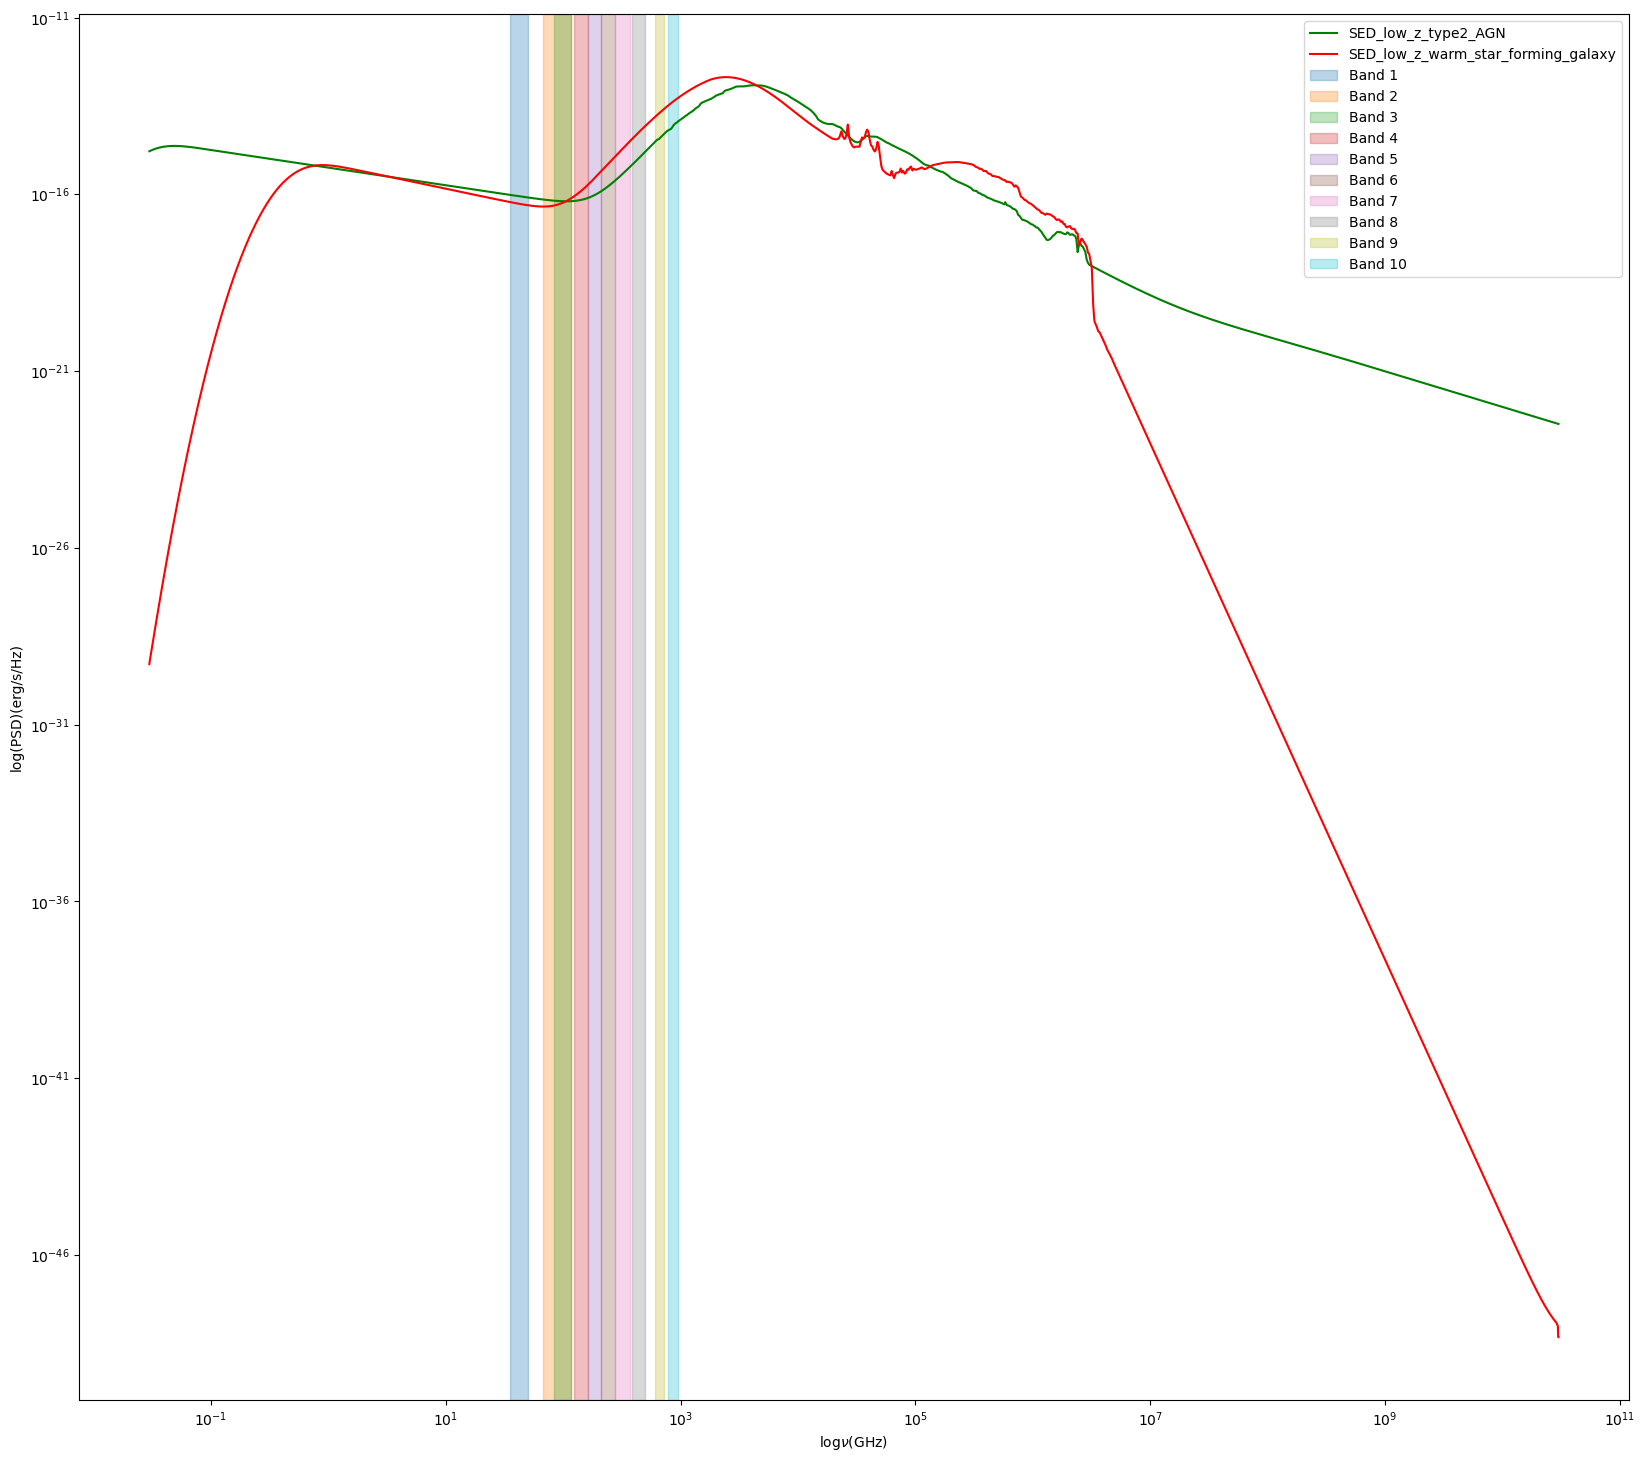

In [4]:
Alma_band= {
    'Band':['Band 1','Band 2','Band 3','Band 4','Band 5','Band 6','Band 7','Band 8','Band 9','Band 10'],
    'Freq_Range' : [
        (35,50),
        (67,116),
        (84,116),
        (125,163),
        (163,211),
        (211,275),
        (275,373),
        (385,500),
        (602,720),
        (787,950),
    ]
}
df=pd.DataFrame(Alma_band)
plt.figure(figsize=[20,18])
plt.plot(db['Frequency'],db['erg/s/Hz'], color='green', label='SED_low_z_type2_AGN')
plt.plot(db2['Frequency'],db2['erg/s/Hz'], color='red',label='SED_low_z_warm_star_forming_galaxy')
color_map = plt.colormaps.get_cmap('tab10')
for index, row in df.iterrows():
    color = color_map(index)
    plt.axvspan(row['Freq_Range'][0], row['Freq_Range'][1], color=color, alpha=0.3, label=row['Band'])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('log$\\nu$(GHz)')
plt.ylabel('log(PSD)(erg/s/Hz)')
plt.legend()
plt.show()

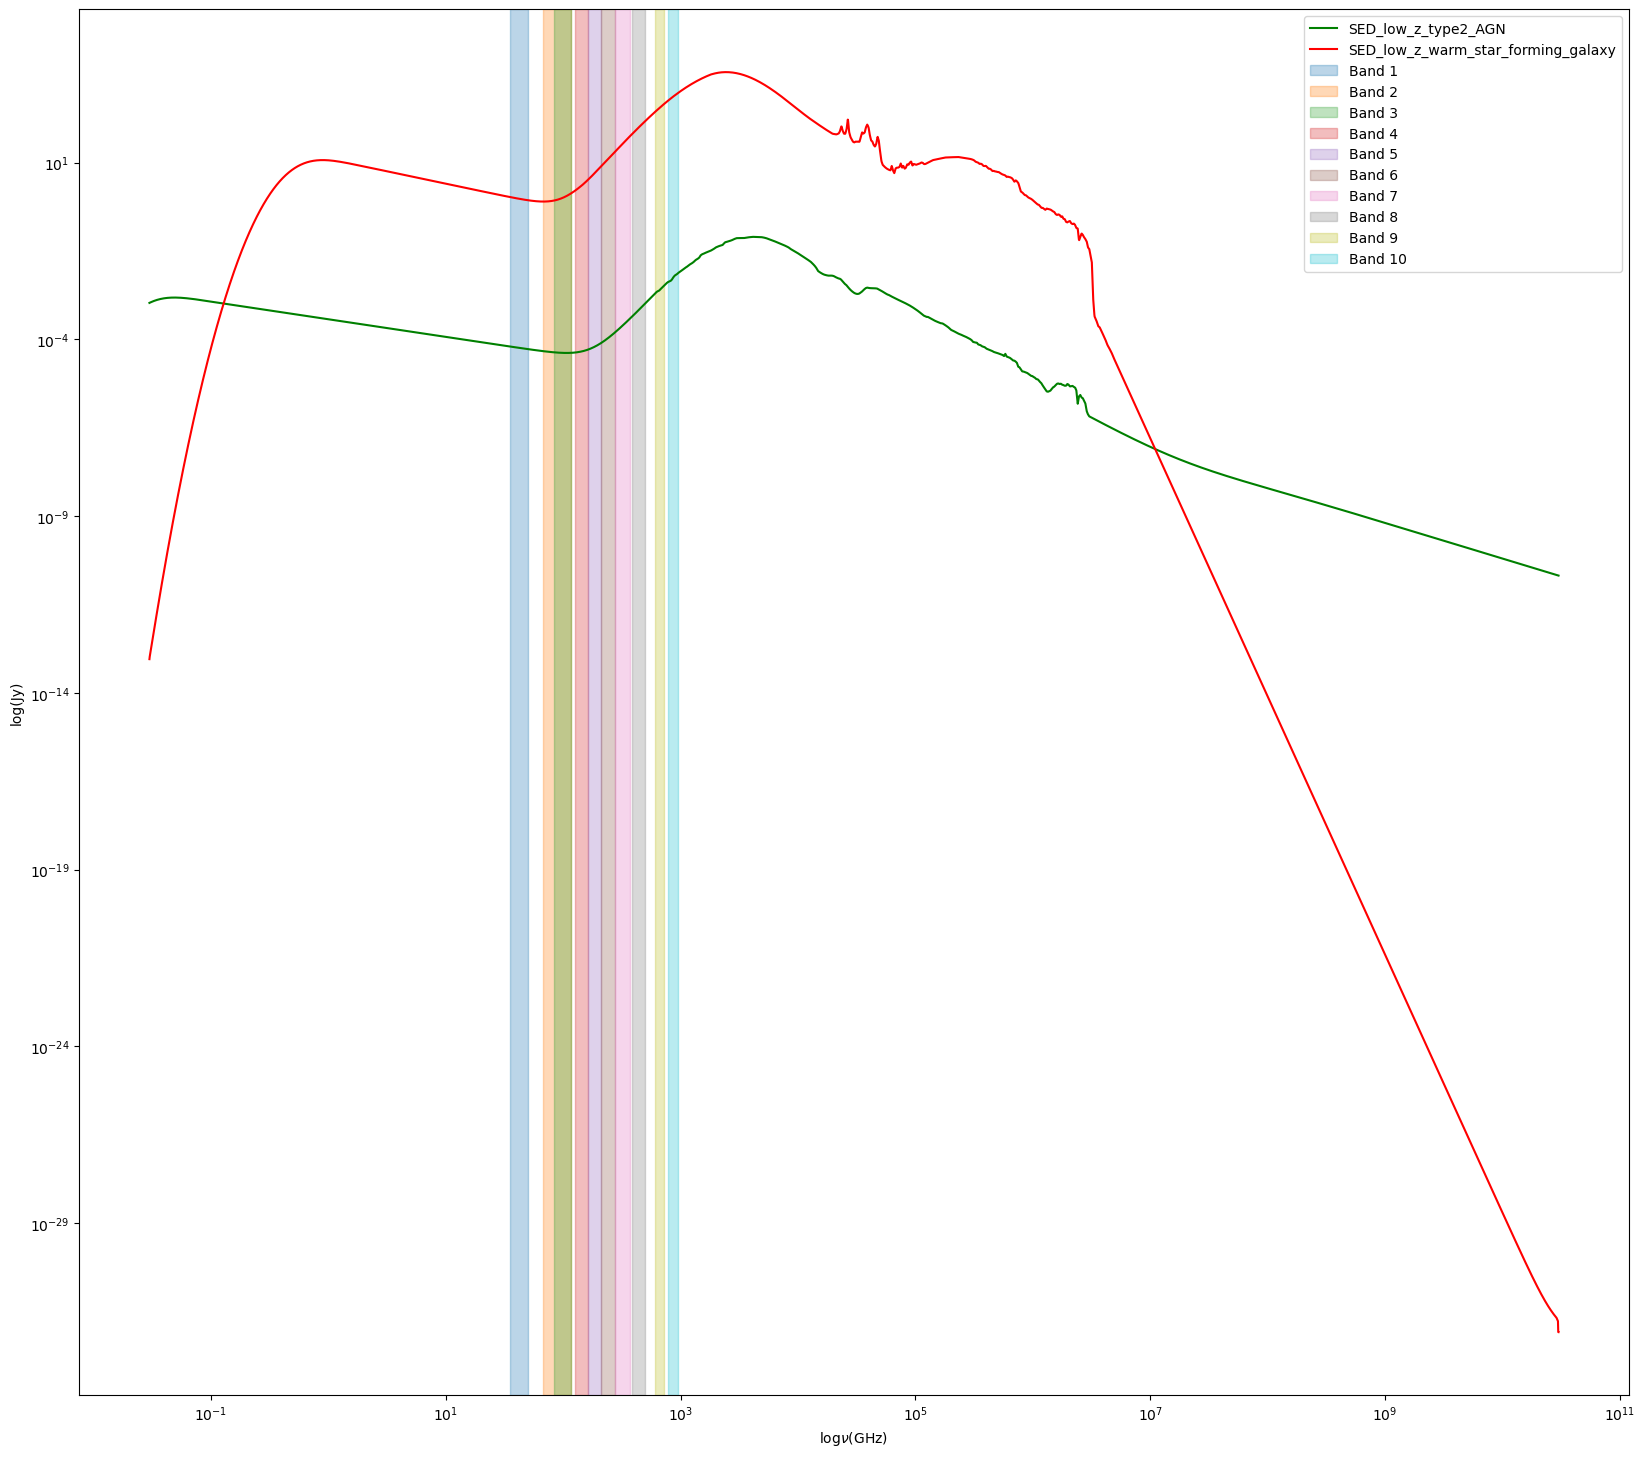

In [10]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
db['Jy']=(db['erg/s/Hz']/((10.**(-26.))*(10.**7.)*4.*np.pi*(cosmo.luminosity_distance(0.05).value*(3.086e+22))**2.))*(3.846e+33*1e+10)
db2['Jy']=db2['erg/s/Hz']/((10.**(-26.))*(10.**7.)*4.*np.pi*(cosmo.luminosity_distance(0.0001).value*(3.086e+22))**2.)*(3.846e+33*1e+9)
plt.figure(figsize=[20,18])
plt.plot(db['Frequency'],db['Jy'], color='green', label='SED_low_z_type2_AGN')
plt.plot(db2['Frequency'],db2['Jy'], color='red',label='SED_low_z_warm_star_forming_galaxy')
color_map = plt.colormaps.get_cmap('tab10')
for index, row in df.iterrows():
    color = color_map(index)
    plt.axvspan(row['Freq_Range'][0], row['Freq_Range'][1], color=color, alpha=0.3, label=row['Band'])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('log$\\nu$(GHz)')
plt.ylabel('log(Jy)')
plt.legend()
plt.show()

In [9]:
print(db)
print(db2)

                um      erg/s/Hz     Frequency            Jy
0     1.000000e-05  3.198450e-23  2.997925e+10  2.080246e-12
1     1.005542e-05  3.216260e-23  2.981402e+10  2.091830e-12
2     1.011114e-05  3.240644e-23  2.964972e+10  2.107689e-12
3     1.016717e-05  3.258718e-23  2.948632e+10  2.119444e-12
4     1.022351e-05  3.276894e-23  2.932383e+10  2.131266e-12
...            ...           ...           ...           ...
4996  9.781377e+06  1.707727e-15  3.064931e-02  1.110692e-04
4997  9.835581e+06  1.693221e-15  3.048040e-02  1.101257e-04
4998  9.890084e+06  1.678610e-15  3.031243e-02  1.091754e-04
4999  9.944890e+06  1.663896e-15  3.014538e-02  1.082185e-04
5000  1.000000e+07  1.649084e-15  2.997925e-02  1.072551e-04

[5001 rows x 4 columns]
                um      erg/s/Hz     Frequency            Jy
0     1.000000e-05  4.758826e-49  2.997925e+10  8.336711e-33
1     1.005542e-05  4.785197e-49  2.981402e+10  8.382909e-33
2     1.011114e-05  9.695765e-49  2.964972e+10  1.698545e-32